In [1]:
import pandas as pd
import numpy as np
import os,re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import xgboost
from sklearn import preprocessing,linear_model, ensemble, metrics
from sklearn.metrics import accuracy_score,average_precision_score
from sklearn.metrics import precision_recall_curve,roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from keras import layers, models, optimizers
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 准备数据

## abstract

In [4]:
abs_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/SIF/abstract/"
docLabels = [f for f in os.listdir(abs_filepath) if f.endswith('.xlsx')]
print("number of docs:{}".format(len(docLabels)))

number of docs:7769


In [5]:
abstract_vextor = []
for doc in tqdm(docLabels, ncols=70):
    data = pd.read_excel(abs_filepath+doc,encoding='utf-8')
    text_embedding = data.mean(axis=0)
    abstract_vextor.append(text_embedding)

100%|█████████████████████████████| 7769/7769 [05:12<00:00, 24.83it/s]


In [6]:
abstract_vextor = np.array(abstract_vextor)
abstract_vextor.shape

(7769, 300)

In [7]:
x_abs = abstract_vextor
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_abs, p=None)
c

136.33412445300365

## claims

In [8]:
claim_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/SIF/claims/"
docLabels = [f for f in os.listdir(claim_filepath) if f.endswith('.xlsx')]
print("number of docs:{}".format(len(docLabels)))

number of docs:7769


In [9]:
claim_vextor = []
for doc in tqdm(docLabels, ncols=70):
    data = pd.read_excel(claim_filepath+doc,encoding='utf-8')
    text_embedding = data.mean(axis=0)
    claim_vextor.append(text_embedding)

100%|█████████████████████████████| 7769/7769 [20:13<00:00,  6.40it/s]


In [10]:
claim_vextor = np.array(claim_vextor)
claim_vextor.shape

(7769, 300)

In [11]:
x_claims = claim_vextor
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_claims, p=None)
c

597.9343227714086

## text_sum

In [12]:
sum_feature = np.concatenate((abstract_vextor,claim_vextor), axis=1)
sum_feature.shape

(7769, 600)

In [13]:
x_text = sum_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_text, p=None)
c

2500.283419083083

## result

In [15]:
result = pd.read_excel("/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result_2010.xlsx", encoding='utf-8')

In [16]:
y_binary = result

In [17]:
train_target = np_utils.to_categorical(result, 2)
train_target.shape

(7769, 2)

In [18]:
y_category = train_target

# 划分训练集

In [19]:
x_abs_train = x_abs[:6215]
x_abs_valid = x_abs[6215:6992]
x_abs_test = x_abs[6992:]

x_claims_train = x_claims[:6215]
x_claims_valid = x_claims[6215:6992]
x_claims_test = x_claims[6992:]

x_text_train = x_text[:6215]
x_text_valid = x_text[6215:6992]
x_text_test = x_text[6992:]

In [52]:
y_binary_train = y_binary[:6215].values.ravel()
y_binary_valid = y_binary[6215:6992].values.ravel()
y_binary_test = y_binary[6992:].values.ravel()

y_category_train = y_category[:6215]
y_category_valid = y_category[6215:6992]
y_category_test = y_category[6992:]

# 机器学习

In [21]:
def train_model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    
    y_predict = classifier.predict(x_test)# 每一个x的预测值
    y_predict_proba = classifier.predict_proba(x_test) # 预测分类的概率
    
    precision = metrics.precision_score(y_test, y_predict) # 精确率
    recall = metrics.recall_score(y_test, y_predict) # 召回率
    f1 = metrics.f1_score(y_test, y_predict) # f1
    accuracy = metrics.accuracy_score(y_test, y_predict, normalize = True) # 准确率
    
    # print("accuracy: {:.4f} precision: {:.4f} recall: {:.4f} f1: {:.4f}".format(accuracy,precision,recall,f1))
    
    return y_predict,y_predict_proba

## abstract

In [369]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=1, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10, criterion='entropy'), 
                      xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [370]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_abs_train, y_binary_train, x_abs_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:08<00:00,  2.79s/it]


In [371]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [372]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5457
LR macro:  0.5021
LR weighted:  0.5493
[0.5457]
[0.5021]
[0.5493]


In [373]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3428    0.3674    0.3547       264
           1     0.6619    0.6374    0.6495       513

    accuracy                         0.5457       777
   macro avg     0.5023    0.5024    0.5021       777
weighted avg     0.5535    0.5457    0.5493       777



In [374]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.5997
macro:  0.4774
weighted:  0.5584
[0.5997]
[0.4774]
[0.5584]


In [375]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3285    0.1705    0.2244       264
           1     0.6578    0.8207    0.7303       513

    accuracy                         0.5997       777
   macro avg     0.4931    0.4956    0.4774       777
weighted avg     0.5459    0.5997    0.5584       777



In [376]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.5573
macro:  0.5269
weighted:  0.5653
[0.5997]
[0.4774]
[0.5584]


In [377]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3734    0.4470    0.4069       264
           1     0.6833    0.6140    0.6468       513

    accuracy                         0.5573       777
   macro avg     0.5284    0.5305    0.5269       777
weighted avg     0.5780    0.5573    0.5653       777



## claims

In [379]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=1, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10, criterion='entropy'), 
                      xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [380]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_claims_train, y_binary_train, x_claims_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:04<00:00,  1.55s/it]


In [381]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [382]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5341
LR macro:  0.5192
LR weighted:  0.5463
[0.5341]
[0.5192]
[0.5463]


In [383]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3697    0.5265    0.4344       264
           1     0.6883    0.5380    0.6039       513

    accuracy                         0.5341       777
   macro avg     0.5290    0.5323    0.5192       777
weighted avg     0.5800    0.5341    0.5463       777



In [384]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.6088
macro:  0.5099
weighted:  0.5804
[0.6088]
[0.5099]
[0.5804]


In [385]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3780    0.2348    0.2897       264
           1     0.6705    0.8012    0.7300       513

    accuracy                         0.6088       777
   macro avg     0.5243    0.5180    0.5099       777
weighted avg     0.5711    0.6088    0.5804       777



In [386]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.5637
macro:  0.5314
weighted:  0.5708
[0.6088]
[0.5099]
[0.5804]


In [387]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3786    0.4432    0.4084       264
           1     0.6859    0.6257    0.6544       513

    accuracy                         0.5637       777
   macro avg     0.5323    0.5345    0.5314       777
weighted avg     0.5815    0.5637    0.5708       777



## text_sum

In [516]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.003, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=8), 
                      xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [517]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_text_train, y_binary_train, x_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:05<00:00,  1.95s/it]


In [518]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [423]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5714
LR macro:  0.5116
LR weighted:  0.5664
[0.5714]
[0.5116]
[0.5664]


In [424]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3568    0.3258    0.3406       264
           1     0.6679    0.6979    0.6826       513

    accuracy                         0.5714       777
   macro avg     0.5124    0.5118    0.5116       777
weighted avg     0.5622    0.5714    0.5664       777



In [519]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.5843
macro:  0.5148
weighted:  0.5737
[0.5843]
[0.5148]
[0.5737]


In [520]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3653    0.3030    0.3313       264
           1     0.6703    0.7290    0.6984       513

    accuracy                         0.5843       777
   macro avg     0.5178    0.5160    0.5148       777
weighted avg     0.5666    0.5843    0.5737       777



In [396]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

acc:  0.5457
macro:  0.5076
weighted:  0.5515
[0.5907]
[0.4986]
[0.5675]


In [397]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3502    0.3939    0.3708       264
           1     0.6667    0.6238    0.6445       513

    accuracy                         0.5457       777
   macro avg     0.5084    0.5089    0.5076       777
weighted avg     0.5591    0.5457    0.5515       777



## 绘图

100%|█| 3/3 [00:00<0


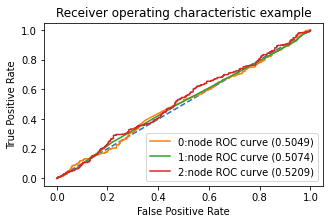

In [378]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


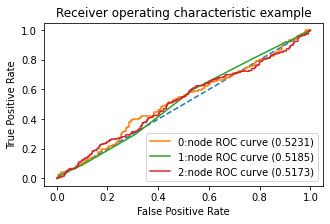

In [388]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


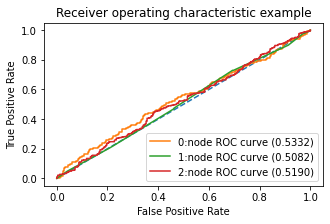

In [491]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 神经网络

In [40]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [349]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    Dense_layer_1 = layers.Dense(360, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(480, activation="relu")(Dense_layer_1)
    Dense_layer_2 = layers.Dropout(0.3)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(128, activation="relu")(Dense_layer_2)
    Dense_layer_3 = layers.Dropout(0.5)(Dense_layer_3)
    Dense_layer_4 = layers.Dense(2, activation='softmax')(Dense_layer_3)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_4)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [350]:
# 提前停止监视器设置为3，这意味着在连续3次运行后，模型的性能没有改进的话，训练将会被停止
my_callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=5)
]
cw = [1.49346405, 0.75164474]

In [351]:
history_list = []
model_list = []

for i in tqdm(range(10), ncols=70):
    model = full_connect_network(x_sum_train.shape[1])
    history = model.fit(x_sum_train, y_category_train, 
                        validation_data=(x_sum_valid, y_category_valid), 
                        verbose=0, epochs=100, batch_size=128, shuffle=False,
                        callbacks=my_callbacks,
                        class_weight=cw)
    history_list.append(history)
    model_list.append(model)

100%|███████████████████████████████████| 5/5 [01:12<00:00, 14.46s/it]


In [332]:
# loss, acc = model.evaluate(x_abs_test, y_category_test, batch_size=128, verbose=1)
# print("accuracy: {:.4f} loss: {:.4f}".format(acc,loss))

In [352]:
metrics_list = []
for model in tqdm(model_list, ncols=70):
    y_pred = model.predict(x_sum_test, batch_size=64, verbose=0)
    y_pred_1 = np.rint(y_pred) #四舍五入取整
    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    report = classification_report(y_category_test, y_pred, digits=4)
    p = re.compile('  |\n', re.S)
    report = p.sub(' ', report)
    metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
    metrics_list.append(metrics_content)

100%|███████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]


In [353]:
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("weighted:  {:.4f}".format(weighted))
print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

acc:  0.6641
macro:  0.4098
weighted:  0.5340


In [354]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.0076    0.0150       264
           1     0.6619    1.0000    0.7966       513

   micro avg     0.6628    0.6628    0.6628       777
   macro avg     0.8310    0.5038    0.4058       777
weighted avg     0.7768    0.6628    0.5310       777
 samples avg     0.6628    0.6628    0.6628       777



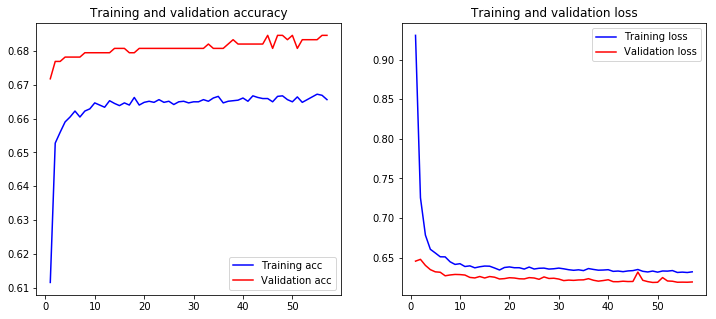

In [355]:
plot_history(history_list[4])